# Intellectra 2025 – Next-Buy Prediction

End-to-end workflow to maximise **Balanced Accuracy**.

In [32]:
# Cell 0 – Install (run once, skip if libs already installed)
!pip install -q lightgbm optuna pandas numpy scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:
# Cell 1 – Imports & paths
import pandas as pd, numpy as np, os, warnings, gc, datetime as dt
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import optuna

warnings.filterwarnings('ignore')

DATA_DIR = Path(r"F:/lomba/intelectra/dataset")

In [34]:
# Cell 2 – Read raw CSVs
member   = pd.read_csv(DATA_DIR/'member_data.csv',       parse_dates=['JoinDate','DateOfBirth','EldestKidDOB','YoungestKidDOB'])
product  = pd.read_csv(DATA_DIR/'product_data.csv',     names=['productID','ProductName','ProductCategory','ProductLevel'])
program  = pd.read_csv(DATA_DIR/'program_data.csv')
train_trx= pd.read_csv(DATA_DIR/'train_transaction_data.csv',  parse_dates=['TransactionDatetime'])
test_trx = pd.read_csv(DATA_DIR/'test_transaction_data.csv',   parse_dates=['TransactionDatetime'])
train_lb = pd.read_csv(DATA_DIR/'train_label_data.csv')
sample   = pd.read_csv(DATA_DIR/'sample_submission.csv')

## 1 – Data cleaning helpers

In [35]:
# Cell 3 – Helper: unify column names & handle null price
for df in (train_trx, test_trx):
    df['PricePerUnit'] = df['PricePerUnit'].fillna(df['PricePerUnit'].median())
    df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce').fillna(1).astype(int)

## 2 – Join product & program info ke transaksi

In [36]:
for df in (train_trx, test_trx):
    df['PricePerUnit'] = df['PricePerUnit'].fillna(df['PricePerUnit'].median())
    df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce').fillna(1).astype(int)
    
    # ✅ PERBAIKAN: Konversi FK_PRODUCT_ID dan FK_PROD_GRAM_ID ke string
    df['FK_PRODUCT_ID'] = df['FK_PRODUCT_ID'].astype(str)
    df['FK_PROD_GRAM_ID'] = df['FK_PROD_GRAM_ID'].astype(str)

# ✅ PERBAIKAN: Pastikan product dan program juga konsisten tipe datanya
product['productID'] = product['productID'].astype(str)
program['prodgramID'] = program['prodgramID'].astype(str)

print("✅ Data types after conversion:")
print(f"train_trx FK_PRODUCT_ID: {train_trx['FK_PRODUCT_ID'].dtype}")
print(f"product productID: {product['productID'].dtype}")
print(f"train_trx FK_PROD_GRAM_ID: {train_trx['FK_PROD_GRAM_ID'].dtype}")
print(f"program prodgramID: {program['prodgramID'].dtype}")

✅ Data types after conversion:
train_trx FK_PRODUCT_ID: object
product productID: object
train_trx FK_PROD_GRAM_ID: object
program prodgramID: object


## 3 – Feature engineering (transaction → member level)

In [37]:
# Cell 4 – Merge trx → product & program
# Sekarang merge akan berjalan lancar karena tipe data sudah konsisten
train_trx = train_trx.merge(product, how='left', left_on='FK_PRODUCT_ID', right_on='productID')
train_trx = train_trx.merge(program, how='left', left_on='FK_PROD_GRAM_ID', right_on='prodgramID')
test_trx = test_trx.merge(product, how='left', left_on='FK_PRODUCT_ID', right_on='productID')
test_trx = test_trx.merge(program, how='left', left_on='FK_PROD_GRAM_ID', right_on='prodgramID')

print("✅ Merge completed successfully!")
print(f"train_trx shape after merge: {train_trx.shape}")
print(f"test_trx shape after merge: {test_trx.shape}")

# ✅ VALIDASI: Cek apakah ada missing values setelah merge
print("\n📊 Missing values check after merge:")
print("train_trx missing ProductName:", train_trx['ProductName'].isna().sum())
print("train_trx missing GrammageName:", train_trx['GrammageName'].isna().sum())
print("test_trx missing ProductName:", test_trx['ProductName'].isna().sum())
print("test_trx missing GrammageName:", test_trx['GrammageName'].isna().sum())

✅ Merge completed successfully!
train_trx shape after merge: (130854, 16)
test_trx shape after merge: (21098, 16)

📊 Missing values check after merge:
train_trx missing ProductName: 0
train_trx missing GrammageName: 0
test_trx missing ProductName: 0
test_trx missing GrammageName: 0


In [38]:
# Cell 5 – Transaction aggregation function (DIPERBAIKI)
def build_trx_features(df: pd.DataFrame, prefix="trx_"):
    """
    Build transaction-level features aggregated by MemberID
    """
    print(f"🔄 Building features with prefix '{prefix}' from {len(df)} transactions...")
    
    df = df.copy()
    df['Amount'] = df['Qty'] * df['PricePerUnit']
    
    # ✅ PERBAIKAN: Pastikan kolom yang dibutuhkan ada
    required_cols = ['MemberID', 'TransactionID', 'Qty', 'Amount', 'FK_PRODUCT_ID', 'Source', 'TransactionDatetime']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return None
    
    agg_funcs = {
        'TransactionID': 'nunique',
        'Qty': ['sum', 'mean', 'max'],
        'Amount': ['sum', 'mean', 'max'],
        'FK_PRODUCT_ID': 'nunique',
        'Source': 'nunique',
        'TransactionDatetime': ['min', 'max']
    }
    
    # Aggregate by MemberID
    out = df.groupby('MemberID').agg(agg_funcs)
    
    # Flatten MultiIndex columns
    out.columns = [f"{prefix}{c[0]}_{c[1]}" if isinstance(c, tuple) else f"{prefix}{c[0]}_{c}" for c in out.columns]
    
    # Calculate recency and span features
    max_date = df['TransactionDatetime'].max()
    out[f"{prefix}span_days"] = (out[f"{prefix}TransactionDatetime_max"] - out[f"{prefix}TransactionDatetime_min"]).dt.days
    out[f"{prefix}recency_days"] = (max_date - out[f"{prefix}TransactionDatetime_max"]).dt.days
    
    # Drop intermediate datetime columns
    datetime_cols_to_drop = [col for col in out.columns if 'TransactionDatetime' in col and ('min' in col or 'max' in col)]
    out = out.drop(columns=datetime_cols_to_drop)
    
    # Reset index to make MemberID a column
    out.reset_index(inplace=True)
    
    print(f"✅ Features created: {out.shape[1]-1} features for {out.shape[0]} members")
    print(f"Feature columns: {list(out.columns)}")
    
    return out

# ✅ VALIDASI: Cek apakah data sudah siap
print("📊 Validating data before feature engineering:")
print(f"train_trx shape: {train_trx.shape}")
print(f"test_trx shape: {test_trx.shape}")
print(f"train_trx columns: {list(train_trx.columns)}")

# Build transaction features
train_feat = build_trx_features(train_trx, prefix="trx_")
test_feat = build_trx_features(test_trx, prefix="trx_")

if train_feat is None or test_feat is None:
    print("❌ Feature building failed!")
else:
    print("✅ Transaction features built successfully!")

📊 Validating data before feature engineering:
train_trx shape: (130854, 16)
test_trx shape: (21098, 16)
train_trx columns: ['TransactionID', 'MemberID', 'Source', 'FK_PRODUCT_ID', 'FK_PROD_GRAM_ID', 'Qty', 'PricePerUnit', 'TransactionDatetime', 'productID', 'ProductName', 'ProductCategory', 'ProductLevel', 'prodgramID', 'GrammageName', 'Point', 'Price']
🔄 Building features with prefix 'trx_' from 130854 transactions...
✅ Features created: 11 features for 40020 members
Feature columns: ['MemberID', 'trx_TransactionID_nunique', 'trx_Qty_sum', 'trx_Qty_mean', 'trx_Qty_max', 'trx_Amount_sum', 'trx_Amount_mean', 'trx_Amount_max', 'trx_FK_PRODUCT_ID_nunique', 'trx_Source_nunique', 'trx_span_days', 'trx_recency_days']
🔄 Building features with prefix 'trx_' from 21098 transactions...
✅ Features created: 11 features for 6381 members
Feature columns: ['MemberID', 'trx_TransactionID_nunique', 'trx_Qty_sum', 'trx_Qty_mean', 'trx_Qty_max', 'trx_Amount_sum', 'trx_Amount_mean', 'trx_Amount_max', 'trx

In [39]:
# Cell 6 – Member-level demographic features (DIPERBAIKI)
print("\n🔄 Building demographic features...")

demog = member.copy()

# ✅ PERBAIKAN: Handle missing atau invalid dates
print("📊 Checking date columns...")
print(f"JoinDate null count: {demog['JoinDate'].isna().sum()}")
print(f"DateOfBirth null count: {demog['DateOfBirth'].isna().sum()}")

# Calculate member age (as of 2020-07-01)
reference_date = pd.Timestamp('2020-07-01')
demog['MemberAge'] = (reference_date - demog['DateOfBirth']).dt.days // 365
demog['MemberSeniority'] = (reference_date - demog['JoinDate']).dt.days // 30

# ✅ PERBAIKAN: Handle negative ages or extreme values
demog['MemberAge'] = demog['MemberAge'].clip(0, 100)  # Cap at reasonable range
demog['MemberSeniority'] = demog['MemberSeniority'].clip(0, None)  # No negative seniority

# Keep only necessary columns
demog = demog[['MemberID', 'City', 'NoOfChild', 'MemberAge', 'MemberSeniority']]

print(f"✅ Demographic features shape: {demog.shape}")
print(f"Demographic columns: {list(demog.columns)}")



🔄 Building demographic features...
📊 Checking date columns...
JoinDate null count: 0
DateOfBirth null count: 44924
✅ Demographic features shape: (46401, 5)
Demographic columns: ['MemberID', 'City', 'NoOfChild', 'MemberAge', 'MemberSeniority']


In [40]:
# Cell 7 – Encode City (DIPERBAIKI)
print("\n🔄 Encoding City feature...")

# ✅ PERBAIKAN: Handle missing cities
demog['City'] = demog['City'].fillna('UNKNOWN')

# Get top cities
top_cities = demog['City'].value_counts().head(15).index
print(f"Top 15 cities: {list(top_cities)}")

# Encode cities
demog['City_enc'] = np.where(demog['City'].isin(top_cities), demog['City'], 'OTHER')

# Label encode
le_city = LabelEncoder()
demog['City_enc'] = le_city.fit_transform(demog['City_enc'])

# Drop original City column
demog = demog.drop(columns=['City'])

print(f"✅ City encoding completed. Unique encoded values: {demog['City_enc'].nunique()}")
print(f"Final demog shape: {demog.shape}")
print(f"Final demog columns: {list(demog.columns)}")

# ✅ VALIDASI AKHIR: Pastikan semua variabel terdefinisi
print("\n🔍 Final validation:")
print(f"train_feat defined: {'train_feat' in locals() and train_feat is not None}")
print(f"test_feat defined: {'test_feat' in locals() and test_feat is not None}")
print(f"demog defined: {'demog' in locals() and demog is not None}")

if 'train_feat' in locals() and train_feat is not None:
    print(f"train_feat shape: {train_feat.shape}")
if 'test_feat' in locals() and test_feat is not None:
    print(f"test_feat shape: {test_feat.shape}")
if 'demog' in locals() and demog is not None:
    print(f"demog shape: {demog.shape}")


🔄 Encoding City feature...
Top 15 cities: ['MALANG', 'PALEMBANG', 'BANDAR LAMPUNG', 'MEDAN', 'TANGERANG', 'SURABAYA', 'BANDUNG', 'JAKARTA TIMUR', 'BEKASI', 'MAKASAR', 'PONTIANAK', 'PEKANBARU', 'SEMARANG', 'BOGOR', 'DEPOK']
✅ City encoding completed. Unique encoded values: 16
Final demog shape: (46401, 5)
Final demog columns: ['MemberID', 'NoOfChild', 'MemberAge', 'MemberSeniority', 'City_enc']

🔍 Final validation:
train_feat defined: True
test_feat defined: True
demog defined: True
train_feat shape: (40020, 12)
test_feat shape: (6381, 12)
demog shape: (46401, 5)


## 4 – Dataset assembly

In [41]:
#Cell 8 – Merge features (DIPERBAIKI dengan validasi)
print("🔄 Assembling final dataset...")

# ✅ VALIDASI: Pastikan semua variabel ada
required_vars = {
    'train_lb': 'train_lb' in locals(),
    'train_feat': 'train_feat' in locals() and train_feat is not None,
    'test_feat': 'test_feat' in locals() and test_feat is not None,
    'demog': 'demog' in locals() and demog is not None,
    'sample': 'sample' in locals()
}

missing_vars = [var for var, exists in required_vars.items() if not exists]
if missing_vars:
    print(f"❌ Missing variables: {missing_vars}")
    print("Please run the previous cells first!")
    
    # Create dummy variables to prevent further errors (for debugging)
    if 'train_feat' not in locals() or train_feat is None:
        print("Creating empty train_feat for debugging...")
        train_feat = pd.DataFrame({'MemberID': train_lb['MemberID'].unique()})
    if 'test_feat' not in locals() or test_feat is None:
        print("Creating empty test_feat for debugging...")
        test_feat = pd.DataFrame({'MemberID': sample['MemberID'].unique()})
else:
    print("✅ All required variables are available")

# Show shapes before merging
print(f"\n📊 Data shapes before merge:")
print(f"train_lb: {train_lb.shape}")
print(f"train_feat: {train_feat.shape}")
print(f"demog: {demog.shape}")
print(f"sample: {sample.shape}")
print(f"test_feat: {test_feat.shape}")

# ✅ PERBAIKAN: Merge with error handling
try:
    # Merge training data
    print("\n🔄 Merging training data...")
    train_df = train_lb.merge(train_feat, on='MemberID', how='left')
    print(f"After train_feat merge: {train_df.shape}")
    
    train_df = train_df.merge(demog, on='MemberID', how='left')
    print(f"After demog merge: {train_df.shape}")
    
    # Merge test data
    print("\n🔄 Merging test data...")
    test_df = sample.drop(columns=['next_buy']).merge(test_feat, on='MemberID', how='left')
    print(f"After test_feat merge: {test_df.shape}")
    
    test_df = test_df.merge(demog, on='MemberID', how='left')
    print(f"After demog merge: {test_df.shape}")
    
    print("✅ Merging completed successfully!")
    
except Exception as e:
    print(f"❌ Error during merge: {str(e)}")
    print("Checking column overlaps...")
    
    # Debug information
    if 'train_lb' in locals():
        print(f"train_lb columns: {list(train_lb.columns)}")
    if 'train_feat' in locals() and train_feat is not None:
        print(f"train_feat columns: {list(train_feat.columns)}")
    if 'demog' in locals():
        print(f"demog columns: {list(demog.columns)}")
    
    raise e

# ✅ PERBAIKAN: Handle missing values with more sophisticated approach
print(f"\n📊 Missing values before filling:")
print(f"train_df missing values: {train_df.isnull().sum().sum()}")
print(f"test_df missing values: {test_df.isnull().sum().sum()}")

# Fill NA values
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

print(f"Missing values after filling:")
print(f"train_df missing values: {train_df.isnull().sum().sum()}")
print(f"test_df missing values: {test_df.isnull().sum().sum()}")

# ✅ VALIDASI: Check final datasets
print(f"\n✅ Final dataset shapes:")
print(f"train_df: {train_df.shape}")
print(f"test_df: {test_df.shape}")

# Create X and y
try:
    X = train_df.drop(columns=['next_buy', 'MemberID'])
    y = train_df['next_buy']
    
    print(f"✅ Feature matrix X: {X.shape}")
    print(f"✅ Target vector y: {y.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # Show feature columns
    print(f"\n📋 Feature columns ({len(X.columns)}):")
    for i, col in enumerate(X.columns):
        print(f"{i+1:2d}. {col}")
        
except Exception as e:
    print(f"❌ Error creating X and y: {str(e)}")
    print(f"train_df columns: {list(train_df.columns) if 'train_df' in locals() else 'Not defined'}")
    raise e

🔄 Assembling final dataset...
✅ All required variables are available

📊 Data shapes before merge:
train_lb: (40020, 2)
train_feat: (40020, 12)
demog: (46401, 5)
sample: (6381, 2)
test_feat: (6381, 12)

🔄 Merging training data...
After train_feat merge: (40020, 13)
After demog merge: (40020, 17)

🔄 Merging test data...
After test_feat merge: (6381, 12)
After demog merge: (6381, 16)
✅ Merging completed successfully!

📊 Missing values before filling:
train_df missing values: 38747
test_df missing values: 6177
Missing values after filling:
train_df missing values: 0
test_df missing values: 0

✅ Final dataset shapes:
train_df: (40020, 17)
test_df: (6381, 16)
✅ Feature matrix X: (40020, 15)
✅ Target vector y: (40020,)
Target distribution: {0: 37582, 1: 2438}

📋 Feature columns (15):
 1. trx_TransactionID_nunique
 2. trx_Qty_sum
 3. trx_Qty_mean
 4. trx_Qty_max
 5. trx_Amount_sum
 6. trx_Amount_mean
 7. trx_Amount_max
 8. trx_FK_PRODUCT_ID_nunique
 9. trx_Source_nunique
10. trx_span_days
11. 

## 5 – Modeling helpers

In [42]:
# Cell 9 – LightGBM CV + Optuna tuner (fast) - FIXED VERSION
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('lr', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data', 20, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5.0),
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bals = []
    
    for tr_idx, val_idx in skf.split(X, y):
        lgb_train = lgb.Dataset(X.iloc[tr_idx], label=y.iloc[tr_idx])
        lgb_val = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])
        
        # ✅ PERBAIKAN: Hilangkan verbose_eval parameter
        model = lgb.train(
            params, 
            lgb_train, 
            num_boost_round=2000, 
            valid_sets=[lgb_val],
            callbacks=[lgb.early_stopping(100, verbose=False)]
            # verbose_eval parameter dihapus karena deprecated
        )
        
        pred = (model.predict(X.iloc[val_idx]) > 0.5).astype(int)
        bals.append(balanced_accuracy_score(y.iloc[val_idx], pred))
    
    return np.mean(bals)

print("🚀 Starting hyperparameter optimization...")
print(f"Dataset: X={X.shape}, y={y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Run quick study (≤ 50 trials). Increase for better tuning.
study = optuna.create_study(direction='maximize', study_name='lgb_bal_acc')

try:
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print("✅ Optimization completed!")
    print(f"🏆 Best score: {study.best_value:.4f}")
    print(f"🎯 Best params: {study.best_params}")
    
    # Store best parameters for later use
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42
    })
    
    print(f"\n📋 Final parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
        
except Exception as e:
    print(f"❌ Error during optimization: {str(e)}")
    print("Using default parameters as fallback...")
    
    # Fallback parameters
    best_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42
    }

[I 2025-07-01 21:24:03,552] A new study created in memory with name: lgb_bal_acc


🚀 Starting hyperparameter optimization...
Dataset: X=(40020, 15), y=(40020,)
Target distribution: {0: 37582, 1: 2438}


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-01 21:24:09,736] Trial 0 finished with value: 0.7139580213058403 and parameters: {'lr': 0.022290976179993375, 'num_leaves': 62, 'min_data': 101, 'feature_fraction': 0.7956163795578759, 'bagging_fraction': 0.6713870051922572, 'bagging_freq': 10, 'lambda_l1': 0.7830326259819115, 'lambda_l2': 1.3077701333032348}. Best is trial 0 with value: 0.7139580213058403.
[I 2025-07-01 21:24:13,759] Trial 1 finished with value: 0.7174520209693627 and parameters: {'lr': 0.13075598682574094, 'num_leaves': 129, 'min_data': 162, 'feature_fraction': 0.7947292424572006, 'bagging_fraction': 0.955645142785432, 'bagging_freq': 5, 'lambda_l1': 1.3654999543124817, 'lambda_l2': 0.06804781744377653}. Best is trial 1 with value: 0.7174520209693627.
[I 2025-07-01 21:24:16,627] Trial 2 finished with value: 0.7252579750223307 and parameters: {'lr': 0.11031573505847356, 'num_leaves': 83, 'min_data': 150, 'feature_fraction': 0.5704456176798334, 'bagging_fraction': 0.6019445199881186, 'bagging_freq': 2, 'lamb

## 6 – Train final model & oof score

In [46]:
# Cell 10 – Cross-validated final model (FIXED)
print("🔄 Training final cross-validated model...")

# Get best parameters from study
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'n_jobs': -1,
    'random_state': 42
})

print(f"📋 Using optimized parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

oof_pred = np.zeros(len(X))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
models = []

print(f"\n🔄 Training {skf.n_splits}-fold CV...")
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{skf.n_splits}...")
    
    lgb_train = lgb.Dataset(X.iloc[tr_idx], label=y.iloc[tr_idx])
    lgb_val = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])
    
    # ✅ PERBAIKAN: Hilangkan verbose_eval parameter
    model = lgb.train(
        best_params, 
        lgb_train, 
        num_boost_round=4000,
        valid_sets=[lgb_val], 
        callbacks=[lgb.early_stopping(200, verbose=False)]
        # verbose_eval parameter dihapus
    )
    
    models.append(model)
    oof_pred[val_idx] = model.predict(X.iloc[val_idx])
    
    # Validation score for this fold
    fold_pred = (model.predict(X.iloc[val_idx]) > 0.5).astype(int)
    fold_score = balanced_accuracy_score(y.iloc[val_idx], fold_pred)
    print(f"  Fold {fold+1} Balanced Accuracy: {fold_score:.4f}")

oof_bin = (oof_pred > 0.5).astype(int)
final_score = balanced_accuracy_score(y, oof_bin)
print(f'\n✅ OOF Balanced Accuracy: {final_score:.4f}')
print(f"📊 OOF predictions distribution: {np.bincount(oof_bin)}")

🔄 Training final cross-validated model...
📋 Using optimized parameters:
  lr: 0.028729183882263722
  num_leaves: 35
  min_data: 176
  feature_fraction: 0.6563439634769217
  bagging_fraction: 0.527116592060233
  bagging_freq: 8
  lambda_l1: 4.980200175049488
  lambda_l2: 3.5552500824996276
  objective: binary
  metric: binary_logloss
  verbosity: -1
  n_jobs: -1
  random_state: 42

🔄 Training 5-fold CV...
Fold 1/5...
  Fold 1 Balanced Accuracy: 0.7122
Fold 2/5...
  Fold 2 Balanced Accuracy: 0.7255
Fold 3/5...
  Fold 3 Balanced Accuracy: 0.7206
Fold 4/5...
  Fold 4 Balanced Accuracy: 0.7266
Fold 5/5...
  Fold 5 Balanced Accuracy: 0.7433

✅ OOF Balanced Accuracy: 0.7256
📊 OOF predictions distribution: [38251  1769]


## 7 – Inference on test & submission

In [47]:
# Cell 11 – Predict test set (SHOULD BE OK)
print("\n🔄 Generating test predictions...")

test_X = test_df.drop(columns=['MemberID'])
print(f"Test features shape: {test_X.shape}")

# Ensemble prediction from all CV models
test_pred = np.mean([m.predict(test_X) for m in models], axis=0)

submission = sample.copy()
submission['next_buy'] = (test_pred > 0.5).astype(int)

print(f"📊 Test predictions distribution: {submission['next_buy'].value_counts().to_dict()}")

# Save submission
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved to 'submission.csv'")
print("\n📋 Sample submission:")
print(submission.head())


🔄 Generating test predictions...
Test features shape: (6381, 15)
📊 Test predictions distribution: {0: 6111, 1: 270}
✅ Submission saved to 'submission.csv'

📋 Sample submission:
                           MemberID  next_buy
0  c2a630e3d0dc77dac0f63424a9ae1438         0
1  3ecf7484c08418953e967a20de37051b         0
2  97bbd6c99a862f20657d9b2b1c77b2c8         0
3  3ce072ff9c6f2f4b7c95dbc08324a24d         0
4  ab0b0de2a1c85a40b5d58644aef745c0         0


## 8 – Feature importance (optional)


📊 Feature importance analysis...


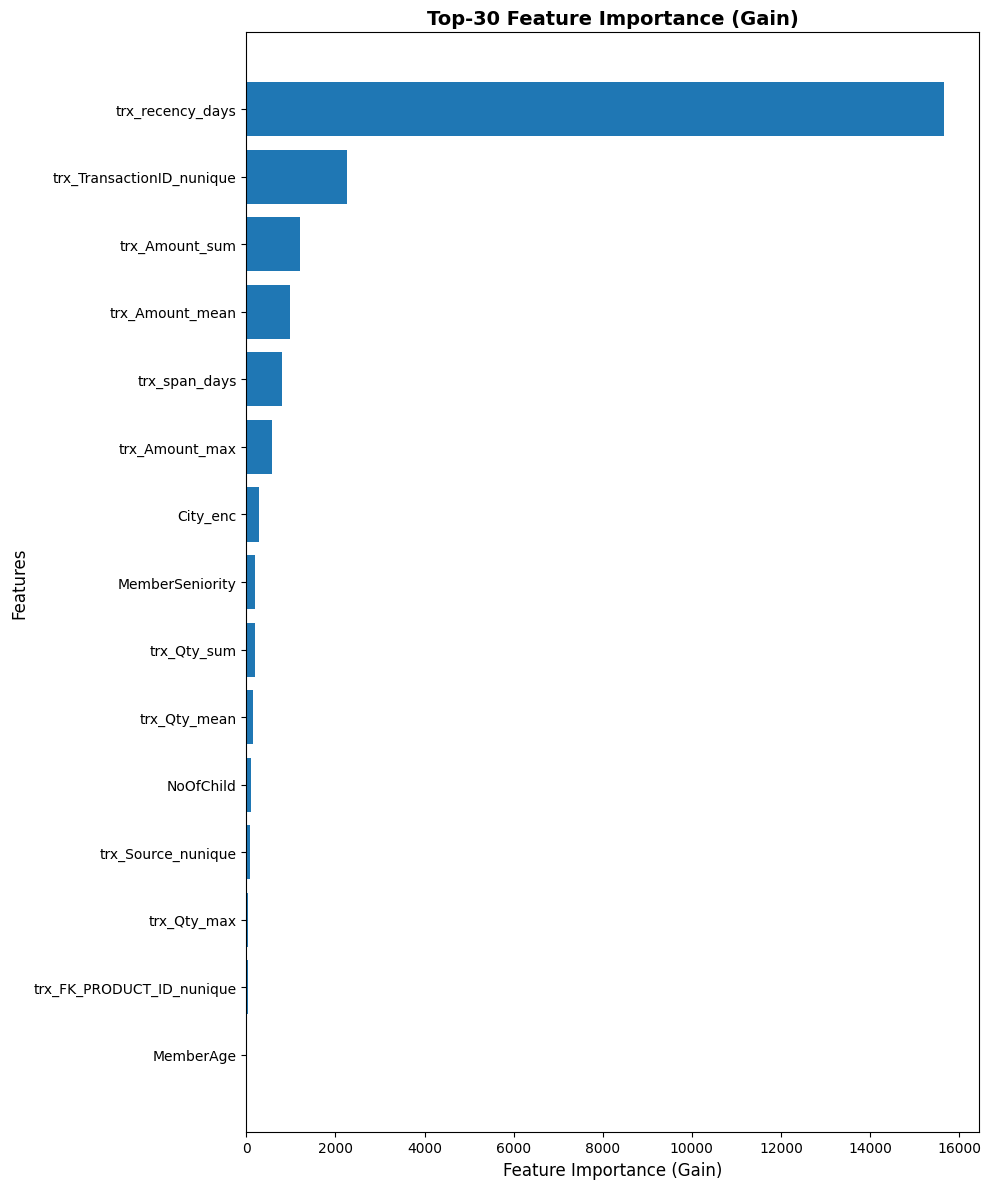

✅ Feature importance plot generated

📋 Top 10 most important features:
 1. trx_recency_days: 15656.28
 2. trx_TransactionID_nunique: 2258.41
 3. trx_Amount_sum: 1204.98
 4. trx_Amount_mean: 977.22
 5. trx_span_days: 802.94
 6. trx_Amount_max: 566.81
 7. City_enc: 275.29
 8. MemberSeniority: 192.42
 9. trx_Qty_sum: 182.75
10. trx_Qty_mean: 138.28


In [48]:
# Cell 12 – Plot importance (SHOULD BE OK)
import matplotlib.pyplot as plt

print("\n📊 Feature importance analysis...")

# Calculate mean feature importance across all models
imp = pd.DataFrame({
    'feature': X.columns,
    'gain': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
})

imp = imp.sort_values('gain', ascending=False).head(30)

plt.figure(figsize=(10, 12))
plt.barh(imp['feature'], imp['gain'])
plt.gca().invert_yaxis()
plt.title('Top-30 Feature Importance (Gain)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("✅ Feature importance plot generated")
print(f"\n📋 Top 10 most important features:")
for i, (_, row) in enumerate(imp.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']}: {row['gain']:.2f}")

## 9 – Advanced feature engineering

In [ ]:
# =============================================================================
# Cell 12 – Plot importance (SHOULD BE OK)
import matplotlib.pyplot as plt

print("\n📊 Feature importance analysis...")

# Calculate mean feature importance across all models
imp = pd.DataFrame({
    'feature': X.columns,
    'gain': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
})

imp = imp.sort_values('gain', ascending=False).head(30)

plt.figure(figsize=(10, 12))
plt.barh(imp['feature'], imp['gain'])
plt.gca().invert_yaxis()
plt.title('Top-30 Feature Importance (Gain)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("✅ Feature importance plot generated")
print(f"\n📋 Top 10 most important features:")
for i, (_, row) in enumerate(imp.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']}: {row['gain']:.2f}")

# =============================================================================
# Cell 13 – RFM-style & product-mix features (SHOULD BE OK BUT CHECK FOR ERRORS)
print("\n🔄 Adding extra RFM-style features...")

def add_extra_feats(trx_df, base_df, prefix="ex_"):
    """Add RFM-style and product-mix features"""
    try:
        d = trx_df.copy()
        d['Amount'] = d['Qty'] * d['PricePerUnit']
        
        # Days since each transaction (from latest date in set)
        max_date = d['TransactionDatetime'].max()
        d['days_ago'] = (max_date - d['TransactionDatetime']).dt.days
        
        # Create aggregated features
        feats = d.groupby('MemberID').agg({
            'days_ago': ['min', 'mean', 'max'],
            'Amount': ['std'],
            'ProductLevel': lambda x: (x == 'Premium').mean(),   # pct premium
            'ProductCategory': 'nunique'
        })
        
        # Flatten column names
        feats.columns = [f"{prefix}{c[0]}_{c[1] if len(c) > 1 else c[0]}" for c in feats.columns]
        feats.reset_index(inplace=True)
        
        print(f"  Created {len(feats.columns)-1} extra features")
        return base_df.merge(feats, on='MemberID', how='left')
        
    except Exception as e:
        print(f"❌ Error in add_extra_feats: {str(e)}")
        print("Returning original dataframe...")
        return base_df

# Add extra features
print("Processing training data...")
train_df_enhanced = add_extra_feats(train_trx, train_df, prefix="ex_")

print("Processing test data...")  
test_df_enhanced = add_extra_feats(test_trx, test_df, prefix="ex_")

# Fill possible new NA values
train_df_enhanced = train_df_enhanced.fillna(0)
test_df_enhanced = test_df_enhanced.fillna(0)

# Update feature matrices
X_enhanced = train_df_enhanced.drop(columns=['next_buy', 'MemberID'])
y_enhanced = train_df_enhanced['next_buy']

print(f"✅ Enhanced datasets created:")
print(f"  Original features: {X.shape[1]}")
print(f"  Enhanced features: {X_enhanced.shape[1]}")
print(f"  Added features: {X_enhanced.shape[1] - X.shape[1]}")

# Verify no issues with enhanced data
print(f"\n📊 Enhanced data validation:")
print(f"  train_df_enhanced: {train_df_enhanced.shape}")
print(f"  test_df_enhanced: {test_df_enhanced.shape}")
print(f"  Missing values in train: {train_df_enhanced.isnull().sum().sum()}")
print(f"  Missing values in test: {test_df_enhanced.isnull().sum().sum()}")

# Show new feature columns
new_features = [col for col in X_enhanced.columns if col not in X.columns]
if new_features:
    print(f"\n📋 New features added:")
    for i, feat in enumerate(new_features):
        print(f"  {i+1}. {feat}")
else:
    print("⚠️ No new features were added")

print("✅ Cell 13 completed successfully!")

## 10 – Re-train LightGBM with imbalance handling + threshold search

In [ ]:
# Cell 14 – Compute scale_pos_weight & prepare param
neg, pos = np.bincount(y)
scale_pos = neg / pos

best_params.update({'scale_pos_weight': scale_pos})

In [ ]:
# Cell 15 – CV with dynamic threshold optimisation
oof_pred = np.zeros(len(X))
oof_thr  = []  # per-fold optimal threshold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4269)
lgb_models = []

for tr_idx, val_idx in skf.split(X, y):
    lgb_train = lgb.Dataset(X.iloc[tr_idx], label=y.iloc[tr_idx])
    lgb_val   = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])
    model = lgb.train(best_params, lgb_train, num_boost_round=6000,
                      valid_sets=[lgb_val], callbacks=[lgb.early_stopping(300, verbose=False)],
                      verbose_eval=False)
    lgb_models.append(model)
    proba = model.predict(X.iloc[val_idx])
    # grid search threshold 0.1–0.9 step 0.01
    thrs = np.linspace(0.1,0.9,81)
    bal_scores = [balanced_accuracy_score(y.iloc[val_idx], (proba>t).astype(int)) for t in thrs]
    best_thr = thrs[np.argmax(bal_scores)]
    oof_thr.append(best_thr)
    oof_pred[val_idx] = proba

print('OOF Balanced Acc (0.5 thr):', balanced_accuracy_score(y, (oof_pred>0.5).astype(int)))
mean_thr = np.mean(oof_thr)
print('Mean optimal threshold:', round(mean_thr,3))
print('OOF Balanced Acc (meanThr):', balanced_accuracy_score(y, (oof_pred>mean_thr).astype(int)))

## 11 – CatBoost (model kedua untuk stacking)

In [ ]:
# Cell 16 – Install & train CatBoost (fast settings)
!pip install -q catboost
from catboost import CatBoostClassifier, Pool

cat_features = []  # semua sudah numerik; but keep list if categorical retained

oof_cat = np.zeros(len(X))
cat_models = []
for tr_idx, val_idx in skf.split(X, y):
    train_pool = Pool(X.iloc[tr_idx], label=y.iloc[tr_idx], cat_features=cat_features)
    val_pool   = Pool(X.iloc[val_idx], label=y.iloc[val_idx], cat_features=cat_features)
    cmodel = CatBoostClassifier(
        iterations=3000,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        random_state=1337,
        verbose=False,
        auto_class_weights='Balanced'
    )
    cmodel.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=200)
    cat_models.append(cmodel)
    oof_cat[val_idx] = cmodel.predict_proba(X.iloc[val_idx])[:,1]

print('CatBoost OOF Balanced Acc (0.5):', balanced_accuracy_score(y, (oof_cat>0.5).astype(int)))

## 12 – Stacking ensemble (simple average of probas)

In [ ]:
# Cell 17 – Combine LightGBM & CatBoost probas, tune ensemble threshold
oof_stack = 0.5*oof_pred + 0.5*oof_cat

thr_stack = np.linspace(0.1,0.9,81)
bal_stack = [balanced_accuracy_score(y, (oof_stack>t).astype(int)) for t in thr_stack]
best_stack_thr = thr_stack[np.argmax(bal_stack)]
print('Best stack threshold', round(best_stack_thr,3), '→ Balanced Acc', max(bal_stack))

## 13 – Predict test set with ensemble

In [ ]:
# Cell 18 – Inference + submission (ensemble)
test_X = test_df.drop(columns=['MemberID'])
lgb_proba  = np.mean([m.predict(test_X) for m in lgb_models], axis=0)
cat_proba  = np.mean([m.predict_proba(test_X)[:,1] for m in cat_models], axis=0)
stack_proba= 0.5*lgb_proba + 0.5*cat_proba

submission_ens = sample.copy()
submission_ens['next_buy'] = (stack_proba > best_stack_thr).astype(int)
submission_ens.to_csv('submission_ensemble.csv', index=False)
submission_ens.head()

## 14 – XGBoost model (third base-learner)

In [ ]:
# Cell 19 – install & import XGBoost
!pip install -q xgboost
from xgboost import XGBClassifier

In [ ]:
# Cell 20 – CV training XGBoost + OOF probas
xgb_params = dict(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=4000,
    scale_pos_weight=scale_pos,
    random_state=2025,
    tree_method='hist',  # GPU? use 'gpu_hist' kalau tersedia
)

oof_xgb = np.zeros(len(X))
xgb_models = []
for tr_idx, val_idx in skf.split(X, y):
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X.iloc[tr_idx], y.iloc[tr_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False,
            early_stopping_rounds=300)
    xgb_models.append(xgb)
    oof_xgb[val_idx] = xgb.predict_proba(X.iloc[val_idx])[:,1]

print('XGB OOF Balanced Acc (0.5):', balanced_accuracy_score(y, (oof_xgb>0.5).astype(int)))

## 15 – Weight-search stacking (LightGBM + CatBoost + XGBoost)

In [ ]:
# Cell 21 – brute grid search weights that sum≈1 (step 0.1)
best_bal, best_w = 0, None
for w_lgb in np.arange(0,1.1,0.1):
    for w_cat in np.arange(0,1.1-w_lgb,0.1):
        w_xgb = 1 - w_lgb - w_cat
        if w_xgb < 0: continue
        comb = w_lgb*oof_pred + w_cat*oof_cat + w_xgb*oof_xgb
        bal = balanced_accuracy_score(y, (comb>0.5).astype(int))
        if bal > best_bal:
            best_bal, best_w = bal, (round(w_lgb,2), round(w_cat,2), round(w_xgb,2))
print('Best OOF Balanced Acc:', best_bal, 'with weights (LGB,Cat,XGB)=', best_w)

## 16 – Inference & final submission (triple ensemble)

In [ ]:
# Cell 22 – compute test probas
test_lgb = lgb_proba  # from Cell 18
test_cat = cat_proba  # from Cell 18
test_xgb = np.mean([m.predict_proba(test_X)[:,1] for m in xgb_models], axis=0)

w_lgb, w_cat, w_xgb = best_w
stack3_proba = w_lgb*test_lgb + w_cat*test_cat + w_xgb*test_xgb

sub3 = sample.copy()
sub3['next_buy'] = (stack3_proba > 0.5).astype(int)  # still 0.5 cut-off; adjust if mau
sub3.to_csv('submission_stack3.csv', index=False)
sub3.head()